downlaod from kMNIST  

https://github.com/rois-codh/kmnist

put them into data/kuzushiji

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
from glob import glob
import datetime
import scipy
import scipy.spatial
import pickle
import skimage
import skimage.transform
from skimage.color import rgb2gray
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [40]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/kuzushiji', one_hot=True)

Extracting ./data/kuzushiji/train-images-idx3-ubyte.gz
Extracting ./data/kuzushiji/train-labels-idx1-ubyte.gz
Extracting ./data/kuzushiji/t10k-images-idx3-ubyte.gz
Extracting ./data/kuzushiji/t10k-labels-idx1-ubyte.gz


In [3]:
str_labels = ['お', 'き', 'す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を']

In [34]:
img, label = mnist.train.next_batch(10)

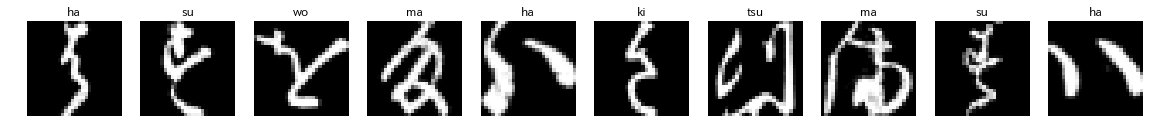

In [35]:
dim = 28

fig, axs = plt.subplots(1, len(img), figsize=(20, 3))

for i, (img, label )in enumerate(zip(img,label)):  
        axs[i].imshow(np.reshape(img, (dim, dim)),cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str_labels[np.argmax(label)])
plt.show()

In [6]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)


def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)


def conv2d(x, filt, name):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """ 
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def avg_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.avg_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def conv_layer(x, out_size, name, act="relu"):
    shape =x.get_shape().as_list()
    in_channel = shape[-1]
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([5,5, in_channel, out_size])
            variable_summaries(W)        
        with tf.name_scope('biases'):
            b = bias_variable([out_size])
            variable_summaries(b)
        h_conv = conv2d(x, W, "conv2d_{}".format(name))
        h = tf.nn.bias_add(h_conv, b)
        variable_summaries(h)
        
    if act == "relu":
        with tf.name_scope("conv_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def fc_layer(x_flatten, out_size, name, act="relu"):
    shape =x_flatten.get_shape().as_list()
    dim = shape[1]
    with tf.name_scope("fc_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([dim, out_size])
        with tf.name_scope('biases'):   
            b  = bias_variable([out_size])
        h = tf.nn.bias_add(tf.matmul(x_flatten, W), b)
      
    if act == "relu":
        with tf.name_scope("fc_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def dropout(x, keep_prob, name):
    with tf.name_scope("dropout_{}".format(name)):
        h = tf.nn.dropout(x, keep_prob)
    return h
    

def flatten(x, name):
    shape = x.get_shape().as_list()
    dim = 1
    for s in shape[1:]:
        dim *= s
    with tf.name_scope(name):
        h = tf.reshape(x, [-1, dim])
    return h


def block(x, out_size, name):
    h_conv_act = conv_layer(x, out_size, name)
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h_conv_act, name)
        variable_summaries(h_pool1)
    return h_pool1


def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [7]:
height = 28
width = 28
image_size = height * width
g1 = None

with tf.Graph().as_default() as g1:
    with tf.name_scope('input'):
        keep_prob = tf.placeholder(tf.float32)
        x = tf.placeholder(tf.float32, shape=[None, None], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, 1])
        tf.summary.image('input',  x_image, 10)

    h_pool1 = block(x_image, 32, "1")
    h_pool2 = block(h_pool1, 64, "2")
    h_pool2_flat = flatten(h_pool2, "pool2_flat")
    h_fc1 = fc_layer(h_pool2_flat, 1024, "1", act="relu")
    h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    y_conv = fc_layer(h_fc1_drop , 10, "2", act="ident")

    with tf.name_scope("loss"):
        print(y_.name)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

input/y-input:0
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
import tensorboard as tb 
tb.show_graph(g1)

In [9]:
n_iter = 5000
batch_size = 100
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
log_dir= "logs/" + time_path  

checkpoint_dir = os.path.abspath(os.path.join(log_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")

tf.gfile.MakeDirs(log_dir)
tf.gfile.MakeDirs(checkpoint_dir)

In [10]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)
    
    for i in tqdm(range(n_iter)):
        batch = mnist.train.next_batch(batch_size)
        _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.6})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        if i % 500 == 0:
            test_accuracy, test_summary, = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            test_writer.add_summary(test_summary, i)
            path = saver.save(sess, checkpoint_prefix, global_step=i)
            print("Saved model checkpoint to {}\n".format(path))
            print('test accuracy %g' % test_accuracy)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

step 0, training loss 8.89909, training accuracy 0.07
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_12_05_47_29/checkpoints/model-0

test accuracy 0.1082
step 100, training loss 0.74762, training accuracy 0.75
step 200, training loss 0.46061, training accuracy 0.83
step 300, training loss 0.470541, training accuracy 0.88
step 400, training loss 0.401283, training accuracy 0.91
step 500, training loss 0.398483, training accuracy 0.87
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_12_05_47_29/checkpoints/model-500

test accuracy 0.7828
step 600, training loss 0.315518, training accuracy 0.92
step 700, training loss 0.306194, training accuracy 0.89
step 800, training loss 0.181197, training accuracy 0.94
step 900, training loss 0.334291, training accuracy 0.92
step 1000, training loss 0.222443, training accuracy 0.94
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_12_05_47_29/checkpoints/model-1000

test accu

In [14]:
ckpt_dir = os.path.join(log_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt

'/Users/tdual/Workspace/cnn_feature/logs/2018_12_12_05_47_29/checkpoints/model-4500'

In [15]:
#latest_ckpt = '/Users/tdual/Workspace/cnn_feature/logs/2018_09_19_00_41_54/checkpoints/model-100'

# similarity

In [16]:
with tf.Session(graph=g1) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt)
    h_fc1_ = sess.run(h_fc1, feed_dict={x: mnist.test.images})
    y_conv_ = sess.run(y_conv, feed_dict={x: mnist.test.images, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from /Users/tdual/Workspace/cnn_feature/logs/2018_12_12_05_47_29/checkpoints/model-4500


In [17]:
h_fc1_[0].shape

(1024,)

In [18]:
y_conv_[0].shape

(10,)

In [19]:
from scipy.spatial import distance
pairwise_10 = distance.squareform(distance.pdist(y_conv_, metric="cosine"))
pairwise_1024 = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [20]:
def similar_to(img_id, num=5, distance=False, pairwise=pairwise_1024):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5, pairwise=pairwise_1024):
    id_list = similar_to(img_id, num=num, distance=True, pairwise=pairwise)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =imgs[id[0]]
        axs[i].imshow(255 - np.reshape(img,[28,28]),cmap='gray')
        axs[i].axis('off')
    plt.show()

In [21]:
imgs = mnist.test.images

(1000, 0.0)
(3966, 0.20066695163570158)
(6413, 0.2307478819293851)
(3968, 0.23711376133015305)
(1412, 0.2435185744272088)
(2200, 0.24501068688498062)
(6491, 0.25319413528268464)
(9504, 0.2563909950942107)
(155, 0.2575073553514261)
(8120, 0.2599623939722706)


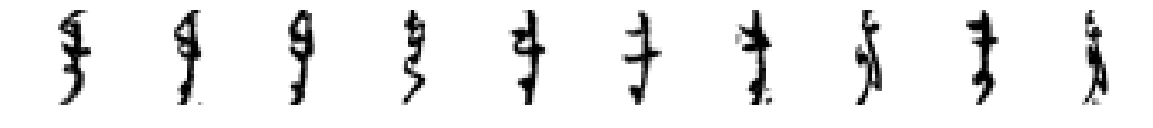

In [22]:
show_sim_image(1000, 10, pairwise=pairwise_1024)

(1000, 0.0)
(2200, 0.033022227089279155)
(1482, 0.04209352439135439)
(2504, 0.042686049227122824)
(7789, 0.045987383573860896)
(2522, 0.047704514135016085)
(2552, 0.049107448594504444)
(9416, 0.05013195757896105)
(5517, 0.05186160547737306)
(1891, 0.0521580069936749)


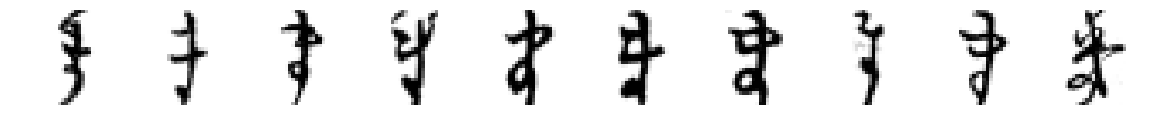

In [23]:
show_sim_image(1000, 10, pairwise=pairwise_10)

(0, 0.0)
(6832, 0.14913561893435856)
(8349, 0.18810990005050077)
(5629, 0.1948786911271959)
(3210, 0.19494846345133443)
(8815, 0.19874585028887992)
(6483, 0.20920099124078595)
(2982, 0.2109422060084205)
(4692, 0.21187051839342408)
(6183, 0.2154924357028648)


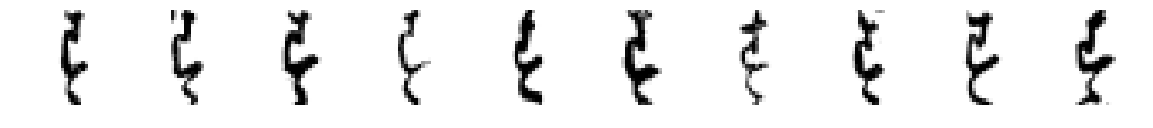

In [24]:
show_sim_image(0, 10)

# Visualization
ref: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/


In [41]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization')


if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [45]:
str_labels = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n" % (index, str_labels[np.argmax(label)]))

In [46]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(mnist.test.images)))

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))

for img in mnist.test.images:
    img_ = np.reshape(img, [height, width]) # reshape and invert grayscale 
    rows.append(img_)

for i in range(sprite_size):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0)#.astype(np.uint8)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)

sprite image size 100 * 100


In [47]:
embedding_var = tf.Variable(mnist.test.images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)

```
tensorboard --logdir=logs/visualization/
```

In [ ]:
test_images = []
orig_images = []
for path in tqdm(imgs):
    img_ = get_resize_img(path , dim) 
    if img_.shape != (28,28,3,):
        print(path)
        print(img_.shape)
        rm_list.append(path)
    else:
        test_images.append(get_flatten_img(path, invert_gray=True))
        orig_images.append(imread(path))
test_images = np.array(test_images)

In [ ]:
test_images = np.reshape(test_images, [-1, 28*28])

In [ ]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: test_images})

In [ ]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [ ]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =orig_images[id[0]]
        axs[i].imshow(img ,cmap='gray')
        axs[i].axis('off')
    plt.show()

In [ ]:
show_sim_image(0,10)

In [ ]:
show_sim_image(2,10)

In [ ]:
len(h_fc1_)

In [ ]:
#with open("mnist_feature.pkl", "wb") as f:
#    pickle.dump(h_fc1_, f)

# faiss

In [ ]:
dim = h_fc1_[0].shape[0]
dim

In [ ]:
h_fc1_.shape

In [ ]:
import faiss
item_index = faiss.IndexFlatL2(dim)
item_index.add(h_fc1_)

In [ ]:
item_index.ntotal

In [ ]:
def show_sim_by_faiss(target_index):
    plt.imshow(orig_images[target_index])
    plt.title("the key image")
    plt.axis('off')
    plt.show()
    key_vec = np.array([h_fc1_[target_index]])
    
    scores, indices = item_index.search(key_vec, 10)
    
    fig, axs = plt.subplots(1, len(indices[0]), figsize=(20, 3))
    for i, (id, s) in enumerate(zip(indices[0], scores[0]) ):
        img =orig_images[id]
        axs[i].imshow(img ,cmap='gray')
        axs[i].set_title(s)
        axs[i].axis('off')
    plt.show()

In [ ]:
show_sim_by_faiss(3)